In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc

import dirUtil 
from highDimLearning import vgg2feat

import tensorflow as tf

from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt


import os
import random 
    

def feat2labels(feat):
    numClass = len(feat)
    numDim = feat[0].shape[1]
    numPts = 0
    for i in range(numClass):
        numPts = numPts + feat[i].shape[0]

    allFeat = np.zeros([numPts, numDim])
    allLabels = np.zeros(numPts, dtype = int)
    cur = 0
    for i in range(numClass):
        allFeat[cur:cur+feat[i].shape[0],:] = feat[i]
        allLabels[cur:cur+feat[i].shape[0]] = i
        cur = cur + feat[i].shape[0]
    return allFeat, allLabels
        
    
def readNetVlad(folder, numDim =4096):
    folderName = os.path.basename(os.path.normpath(folder))
    print(folderName)
    file = folder +'/vd16_pitts30k_conv5_3_vlad_preL2_intra_white_' +folderName + '_db.bin'    
    data = np.fromfile(file, '<f4')
    numPts = int(len(data)/numDim)
    return np.reshape(data, [numPts, numDim])

from scipy.optimize import linear_sum_assignment

def cluster_acc(Y_pred, Y):
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    
    print(w[row_ind,col_ind])
    return w[row_ind,col_ind].sum()/Y_pred.size, w



Using TensorFlow backend.
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python

In [108]:
from resnet_features import multi_folders_to_feature
from dirUtil import unit_norm

feat_path = '/media/daniel/D/Data/daniel_feat'
folder_path = '/media/daniel/D/Data/daniel_images'
multi_folders_to_feature(feat_path, folder_path)

In [109]:
#list_of_folders = ['Flickr11K', 'human', 'women', 'man', 'child', 'man african', 'man asian', 'man european', 'woman african', 'woman asian', 'woman european', 'elderly']
#list_of_folders = ['Flickr11K', 'human', 'women', 'man', 'child']
#list_of_folders = ['woman african', 'woman asian', 'woman european']

list_of_folders = [ 'dog', 'cat']

target = len(list_of_folders)-1

In [110]:
all_feat = []
for f in list_of_folders:
    all_feat.append(np.load(feat_path+'/' +f +'.npy'))
    

    

In [112]:
test_feat = np.load(feat_path+'/Flickr11K.npy')
img_paths = np.load(feat_path+'/Flickr11K_paths.npy')

new_img_paths = []
for p in img_paths:
    new_img_paths.append(folder_path +'/Flickr11K/' + p)
    

In [113]:
def get_means_list(feat):
    num_clus = len(feat)
    means = np.zeros([num_clus, feat[0].shape[1]])
    for i in range(num_clus):
        means[i] = np.mean(feat[i], axis =0)
    return means


def sorted_neighbors_of_i(m_all, i):
    neighbors = np.zeros(m_all.shape[0])
    for j in range(m_all.shape[0]):
        neighbors[j] = np.linalg.norm(m_all[i,:]-m_all[j,:])
    return neighbors, np.argsort(neighbors)

m_all = get_means_list(all_feat)

In [134]:

tf.reset_default_graph()
K.clear_session()

def multiModelB(feat1, feat2, mean1, mean2, sig_est1, sig_est2, weight=0.0, numIter=10000):
    tot = feat1.shape[0]+feat2.shape[0]

    f_1 = tf.constant(feat1, dtype="float32")
    f_2 = tf.constant(feat2, dtype="float32")

    w1 = tf.get_variable("w1", dtype=tf.float32,
                         initializer=mean1)
    w2 = tf.get_variable("w2", dtype=tf.float32,
                         initializer=mean2)

    sig1 = tf.get_variable("s1", dtype=tf.float32,
                           initializer=sig_est1)
    sig2 = tf.get_variable("s2", dtype=tf.float32,
                           initializer=sig_est2)

    lambda_ = tf.constant(weight, dtype="float32")


   


    projDist_1a = tf.math.pow(tf.matmul(f_1, w1) -sig1, 2)
    projDist_1b = tf.math.pow(tf.matmul(f_1, w2) -sig2, 2)
    
    projDist_2a = tf.math.pow(tf.matmul(f_2, w1) -sig1, 2)
    projDist_2b = tf.math.pow(tf.matmul(f_2, w2) -sig2, 2)
    
    e = tf.reduce_sum(projDist_1a/(projDist_1b+0.01)) + tf.reduce_sum(projDist_2b/(projDist_2a+0.01))
    e = e/tot
    
    a = tf.math.square(tf.matmul(tf.transpose(w2),w1))
    b = tf.math.square(1- tf.reduce_sum(tf.math.square(w1)))
    c = tf.math.square(1- tf.reduce_sum(tf.math.square(w2)))
    regularizer_ = a + b + c + 0.0*tf.math.abs(1-sig1) +  0.0*tf.math.abs(1-sig2) 


    
    
    final_cost = e+  lambda_*regularizer_ 

    optimizer = tf.train.AdamOptimizer(0.1)
    train = optimizer.minimize(final_cost)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(numIter):
            sess.run(train)
            if i%500 == 0:
               
                d = sess.run(final_cost)
                f = sess.run(b)

                print(i, d, f)


        w1 = sess.run(w1)
        w2 = sess.run(w2)
        sig1 = sess.run(sig1)
        sig2 = sess.run(sig2)

    return w1, w2, sig1, sig2

feat1 = all_feat[0]
feat2 = all_feat[1]

m = 0.5*np.mean(feat1, axis =0) + 0.5*np.mean(feat2, axis =0)

tf1 = unit_norm(feat1-m)
tf2 = unit_norm(feat2-m)
mean1 = np.mean(tf1, axis =0, keepdims=True)
mean1 = mean1/np.linalg.norm(mean1)
mean2 = np.mean(tf2, axis =0, keepdims=True)
mean2 = mean2/np.linalg.norm(mean2)
sig_est1 = np.mean(np.matmul(tf1, np.transpose(mean1)))
sig_est2 = np.mean(np.matmul(tf2, np.transpose(mean2)))

print(mean1.shape)


w1, w2, sig1, sig2 = multiModelB(tf1, tf2, np.transpose(mean1), np.transpose(mean2), sig_est1, sig_est2, weight=0.1, numIter=10000)

(1, 2048)
0 [[80.8958]] 282.24945
500 [[0.00011448]] 3.864217e-08
1000 [[5.0872977e-06]] 6.5689676e-10
1500 [[2.738528e-07]] 1.114131e-11
2000 [[1.5061548e-08]] 5.684342e-14
2500 [[7.683367e-10]] 0.0
3000 [[6.6264874e-05]] 3.1610953e-06
3500 [[0.00114001]] 0.00015168064
4000 [[0.00707882]] 0.0024958723
4500 [[0.00416823]] 0.0004864033
5000 [[0.74714386]] 0.025639946
5500 [[0.5127876]] 0.05779082
6000 [[0.00208932]] 2.0648217e-06
6500 [[0.00043961]] 3.5926462e-08
7000 [[0.00014214]] 2.993957e-09
7500 [[5.1008625e-05]] 3.1338132e-10
8000 [[1.852168e-05]] 2.5668356e-11
8500 [[6.31958e-06]] 9.094947e-13
9000 [[1.9176325e-06]] 5.684342e-14
9500 [[4.929848e-07]] 1.2789769e-13


(2048, 1)
(2048, 1)


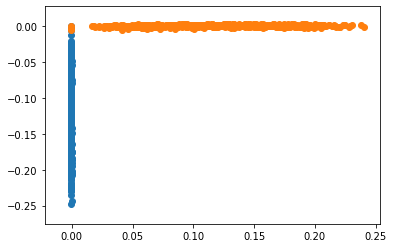

In [135]:
print(w1.shape)
x = np.matmul(tf1, w1)-sig1
y = np.matmul(tf1, w2)-sig2
plt.scatter(x,y)

print(w1.shape)
x = np.matmul(tf2, w1)-sig1
y = np.matmul(tf2, w2)-sig2
plt.scatter(x,y)

#x = np.matmul(tf1, np.transpose(w1))

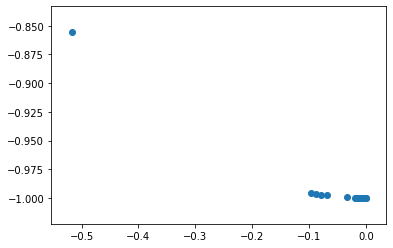

In [152]:
tr =  np.concatenate([np.matmul(tf1, w1)-sig1, np.matmul(tf1, w2)-sig2], axis =1)
tr = tr/np.linalg.norm(tr, keepdims=True, axis =1)

plt.scatter(tr[:,0], tr[:,1])

tr =  np.concatenate([np.matmul(tf2, w1)-sig1, np.matmul(tf2, w2)-sig2], axis =1)
tr = tr/np.linalg.norm(tr, keepdims=True, axis =1)



(11282, 2)


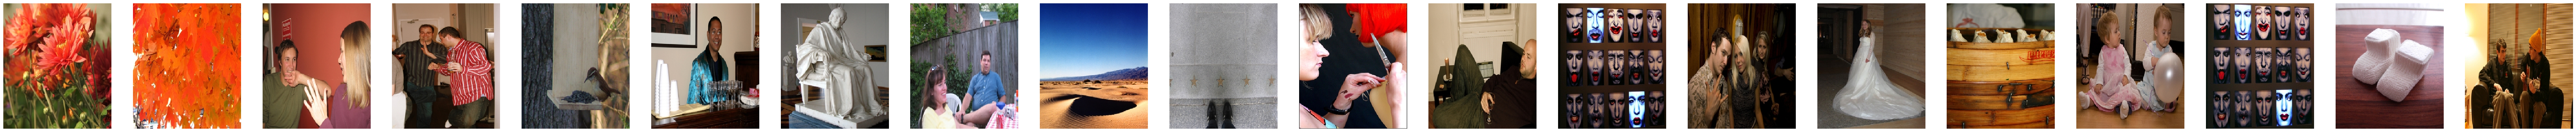

In [151]:
from sklearn.neighbors.kde import KernelDensity

tr =  np.concatenate([np.matmul(tf1, w1)-sig1, np.matmul(tf1, w2)-sig2], axis =1)
tr = tr/np.linalg.norm(tr, keepdims=True, axis =1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(tr)



test_feat = np.load(feat_path+'/Flickr11K.npy')
img_paths = np.load(feat_path+'/Flickr11K_paths.npy')

new_img_paths = []
for p in img_paths:
    new_img_paths.append(folder_path +'/Flickr11K/' + p)

tsf = unit_norm(test_feat-m)
s = np.squeeze(np.matmul(tsf, w2)-sig2)
tsf = np.concatenate([np.matmul(tsf, w1)-sig1, np.matmul(tsf, w2)-sig2], axis =1)
tsf = tsf/np.linalg.norm(tsf, keepdims=True, axis =1)
print(tsf.shape)
s = kde.score_samples(tsf) 
rank_top_images(-s, new_img_paths, start=0, n_display=20)

In [93]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

def stacked_classifer_linearSVM(train_feat, target, all_feat, m_all):
    _, neighs = sorted_neighbors_of_i(m_all, target)
    classifers = []
    current_shell = []
    for i in neighs:
        current_shell.append(i)
        if len(current_shell)> 1:
            
            adv_feat = []
            for j in current_shell:
                if not j == target:
                    adv_feat.append(all_feat[j])
            adv_feat = np.concatenate(adv_feat, axis =0)
            s_gt = np.zeros(train_feat.shape[0]+adv_feat.shape[0])
            s_gt[:train_feat.shape[0]] = 1
            tmp_feat = np.concatenate([train_feat, adv_feat], axis=0)
            m1 = np.mean(m_all[current_shell,:], axis =0, keepdims=True)
            tf = tmp_feat-m1
            tf = tf/np.linalg.norm(tf, axis =1, keepdims=True)
            clf1 = LinearSVC().fit(tf, s_gt)
            classifers.append({'mean': m1, 'classifer': clf1})
    return classifers

m_ex = np.concatenate([np.zeros([1, m_all.shape[1]]), m_all])

classifers = stacked_classifer_linearSVM(all_feat[target], target+1, all_feat, m_ex)

test_feat = np.load(feat_path+'/Flickr11K.npy')
img_paths = np.load(feat_path+'/Flickr11K_paths.npy')

new_img_paths = []
for p in img_paths:
    new_img_paths.append(folder_path +'/Flickr11K/' + p)

def score_samples_linearSVM(classifers, test_feat):
    score = np.zeros([test_feat.shape[0], len(classifers)])
    for i in range(len(classifers)):
        m = classifers[i]['mean']
        tsf = test_feat-m
        tsf = tsf/np.linalg.norm(tsf, keepdims=True, axis =1)
        s = classifers[i]['classifer'].decision_function(tsf)   
        score[:,i] = s
    return score

s = score_samples_linearSVM(classifers, test_feat)
s = np.mean(s, axis =1)



In [38]:
from sklearn.svm import LinearSVC

m = np.mean(train_feat, axis =0)
tf = unit_norm(train_feat-m)
tsf = unit_norm(test_feat-m)
s_gt = np.zeros(train_feat.shape[0]+test_feat.shape[0])
s_gt[:train_feat.shape[0]] = 1
tmp_feat = np.concatenate([tf, tsf], axis=0)

clf1 = LinearSVC().fit(tmp_feat, s_gt)

s = clf1.decision_function(tsf)


NameError: name 'train_feat' is not defined

In [95]:
from sklearn.svm import LinearSVC

target = len(all_feat)-1
adv_feat = []
for j in range(0,len(all_feat)):
    if not j == target:
        adv_feat.append(all_feat[j])
adv_feat = np.concatenate(adv_feat, axis =0)
train_feat = all_feat[target]

m = np.mean(np.concatenate(all_feat), axis =0)

s_gt = np.zeros(train_feat.shape[0]+adv_feat.shape[0])
s_gt[:train_feat.shape[0]] = 1
tmp_feat = np.concatenate([train_feat, adv_feat], axis=0)
tmp_feat = unit_norm(tmp_feat-m)
clf1 = LinearSVC().fit(tmp_feat, s_gt)
test_feat = unit_norm(test_feat-m)
s = clf1.decision_function(test_feat)


In [121]:
import cv2
def rank_top_images(scores, image_paths, start=0, n_display=5):
    nrows = 1
    rank = np.argsort(scores)
    num_imgs = len(image_paths)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=n_display//nrows, squeeze=False,
                           dpi=100, sharex=True, sharey=True, figsize=[(n_display//nrows)*5, 5*nrows])
    ax = ax.flatten()
    for i in range(n_display):
        ax[i].axis('off')
        if i < n_display:
            img = cv2.imread(image_paths[rank[num_imgs-start-1-i]])
            img = np.flip(img, 2)
            ax[i].imshow(img, aspect='auto')
            
rank_top_images(s, new_img_paths, start=100, n_display=20)

NameError: name 's' is not defined

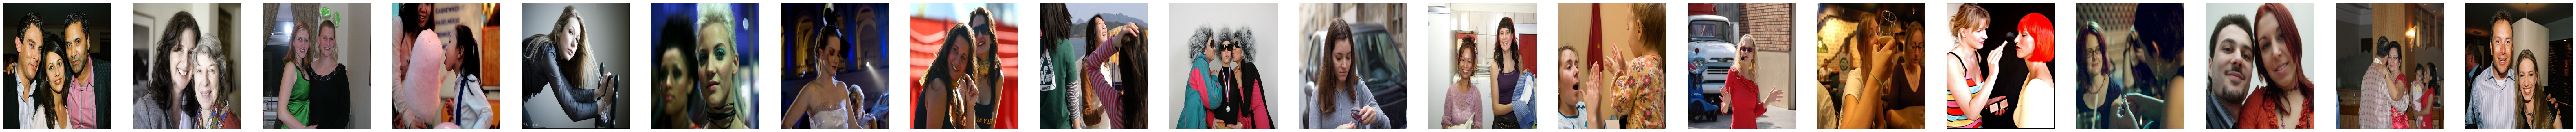

In [41]:
from dirUtil import unit_norm
 
clf = OneClassSVM(gamma='auto').fit(unit_norm(all_feat[target]))
s_old = clf.score_samples(unit_norm(test_feat))   

rank_top_images(s_old, new_img_paths, start=0, n_display=20)
